In [24]:
# Imports:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import statsmodels.api as sm

%matplotlib inline

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

source: [display all output from a jupyter cell](https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result)

In [25]:
path_train = '../datasets/train.csv'
path_test = '../datasets/test.csv'

#read in training data

ames_df = pd.read_csv(path_train)

In [26]:
test = pd.read_csv(path_test)
test.shape

(878, 80)

# Functions

### Functions to treat columns

In [27]:
#Functions being used to featurize columns

def replace_nulls_closest_mean_category (df, col, target):
    '''
    replaces nulls in the col column of df with the value of col
    of the category whose target_mean is closest to target_value in the null column
    
    return copy of df with the new 'col' column
    
    '''
    
    data = df.copy()
    averages = data.groupby(col)[[target]].agg(['mean','count']).reset_index()
    nulls = data.loc[data[col].isnull(),[col, target]]
    for i in nulls.index:
        x = nulls.loc[i,target]
        averages['to_replace'] = x 
        averages['distances'] = (averages[(target, 'mean')] - x).abs()
        min_distance = averages['distances'].min()    
        data.loc[i,col] = averages.loc[averages['distances'] == min_distance,col].mean()
    return data


def mean_encode_discrete_variable(discrete_variable, target, df):
    ''' returns a copy of the DataFrame df where the discrete_variable column 
    is replaced with a mean (target mean) encoded version of the column
    TODO: treat null values
    '''
    X = df.groupby([discrete_variable])[[target]].mean()
    new_df = df.copy()
    new_df[discrete_variable] = new_df[discrete_variable].map(lambda x : X.loc[x,target])
    return new_df



### Plotting functions and others

In [28]:
def create_bins_cts_variable(continuous_variable, df):
    '''
    divide continuous variable into deciles and 
    return a copy of df with an additional column 'continuous_variable_bins' 
    indicating the bin to which each row belongs
    '''
    df_copy = df.copy()
    df_copy[f'{continuous_variable}_bins'] = pd.qcut(df_copy[continuous_variable],10, duplicates = 'drop')
    return df_copy

def numerical_to_categorical_and_plot(category, target, df):
    '''
bins numerical columns into 10 bins with equal # observations and 
plots mean of target column for each bin vs bin average
TODO: 
include a plan to deal with missing values when binning the category column. 
add the average number of observations in each bin to the graphs
Didn't look up pd.qcut does with missing values

'''
    
    df_copy = df.copy()
    df_copy[f'{category}_bins'] = pd.qcut(df_copy[category],10, duplicates = 'drop')
    result_df = df_copy.groupby(f'{category}_bins').agg({target:['mean', 'count']})
    result_df[f'{category}_bin_average']=[round(a.mid) for a in result_df.index]
    result_df.columns = result_df.columns.to_flat_index()
    result_df.columns = [x[0]  if x[1] == '' else x[0]+'_'+x[1] for x in result_df.columns]
    fig, ax = plt.subplots()
    sns.lineplot(x = f'{category}_bin_average', y = f'{target}_mean' , data = result_df,         
                    ax = ax, color = '#0b5394');   
    return result_df


def plot_bar_line(category, target, df, sort = False):
    
    
    '''
    creates the following two plots on a single figure with two y-axes 
    for category and target columns of a df
    1. left y-axis: bar graph mean of target per category
    2. right y-axes: line plot of # of observations in each value of category in df
    
    If sort = True, the bars are ordered in descending values of the mean of target

    TODO: fix order of xticks for category '''
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    if sort:

        df1 = (
            df.groupby([category])[target].mean()
            .to_frame().reset_index().sort_values(by = target, ascending = False)
        )
    else:
        df1 = (
            df.groupby([category])[target].mean()
            .to_frame().reset_index()
        )
        
    
    df2 =(df[category].value_counts(sort = False)
          .rename_axis(category).to_frame('Counts').reset_index()
    )
 
    
    
    df = df1.merge(df2, how ='left', on = category)
        
    df[category] = df[category].astype(str)

    sns.barplot(x = category, y = target, data = df, ci = False, 
                ax = ax1, color = '#0b5394')
    sns.lineplot(x = category , y = 'Counts', data = df, 
                 ax = ax2, color = 'red',marker = 'o'  );

    ax1.set_xlabel(category, color = 'black')
    ax1.set_ylabel(f'{target}_mean',color = '#0b5394')
    ax2.set_ylabel('# Observations',color = 'red');
    


# Exploratory Data Analysis

In [29]:
ames_df.head()
ames_df.shape
ames_df.columns
ames_df.dtypes

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
0        RRAe        Norm      1Fam      2Story             6             8   
1        Norm        Norm      1Fam      2Story             7             5   
2        Norm        Norm      1Fam      1Story             5             7   
3        Norm        Norm      1Fam      2Story             5             5   
4        Norm        Norm      1Fam      1.5Fin             6             8   

   Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st Exterior 2nd  \
0        1976            2005      Gable   CompShg      HdBoard      Plywood   
1        1996            1997      Gable   CompShg      VinylSd      VinylSd   
2        1953            2007      Gable   CompShg      VinylSd      VinylSd   
3        2006            2007      Gable   CompShg      VinylSd      VinylSd   
4        1900            1993      Gable   CompShg      Wd Sdng      Plywood   

  Mas Vnr Type  Mas Vnr Area Exter Qual Exter Cond Foundation Bsmt Qual  \
0      BrkFace         289.0         Gd         TA     CBlock        TA   
1      BrkFace         132.0         Gd         TA      PConc        Gd   
2         None           0.0         TA         Gd     CBlock        TA   
3         None           0.0         TA         TA      PConc        Gd   
4         None           0.0         TA         TA      PConc        Fa   

  Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1 BsmtFin Type 2  \
0        TA            No            GLQ         533.0            Unf   
1        TA            No            GLQ         637.0            Unf   
2        TA            No            GLQ         731.0            Unf   
3        TA            No            Unf           0.0            Unf   
4        Gd            No            Unf           0.0            Unf   

   BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF Heating Heating QC Central Air  \
0           0.0        192.0          725.0    GasA         Ex           Y   
1           0.0        276.0          913.0    GasA         Ex           Y   
2           0.0        326.0         1057.0    GasA         TA           Y   
3           0.0        384.0          384.0    GasA         Gd           Y   
4           0.0        676.0          676.0    GasA         TA           Y   

  Electrical  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
0      SBrkr         725         754                0         1479   
1      SBrkr         913        1209                0         2122   
2      SBrkr        1057           0                0         1057   
3      SBrkr         744         700                0         1444   
4      SBrkr         831         614                0         1445   

   Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2  

(2051, 81)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

### Treating missing values and outliers

In [30]:
null_counts = ames_df.isnull().sum() 

#list of column names with nulls
columns_with_nulls = null_counts[null_counts>0].index 


null_counts[columns_with_nulls]

#dropping columns in which more than 40% of the observations are missing
cols_to_drop = [col for col in columns_with_nulls if null_counts[col] > 0.4*ames_df.shape[0]]
print(f'#columns being dropped: {len(cols_to_drop)} and these are {cols_to_drop}')




Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

#columns being dropped: 5 and these are ['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']


In [35]:


cat_columns = ames_df.select_dtypes(object).columns

discrete_columns = ['MS SubClass', 'Overall Qual','Overall Cond', 'Year Built', 'Year Remod/Add', 
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars',  'Misc Val', 'Mo Sold', 'Yr Sold']
continuous_columns = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area','Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area']
ames_df[continuous_columns].describe(percentiles = [0.01,0.1,0.25,0.5, 0.6, 0.75,0.9,0.99])
ames_df[discrete_columns].describe(percentiles = [0.01,0.1,0.25,0.5, 0.6, 0.75,0.9,0.99])

# # drop columns if more than 40% of the entries are 0
# more_cols_to_drop = []
# for col in discrete_columns + continuous_columns:
#     if ames_df.loc[ames_df[col] == 0,col].shape[0] > 0.4*ames_df.shape[0]:
#         more_cols_to_drop.append(col)

# more_cols_to_drop


# #drop the columns and modify the df

df_no_nulls = ames_df.drop(columns = cols_to_drop)

# Columns where null values will be imputed using some strategy
cols_to_impute = [col for col in columns_with_nulls if col not in cols_to_drop]
print(f'#columns to impute: {len(cols_to_impute)}. They are {cols_to_impute}')

imputed_df = df_no_nulls
for col in cols_to_impute:
    if col in cat_columns + discrete_columns:
        imputed_df[col] = imputed[col].fillna(imputed_df[col].mode())
    else:
        imputed_df[col] = imputed[col].fillna(imputed_df[col].mean())
        
imputed_df.dtypes()
impyted_df.isnull().sum()

Lot Frontage       Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
count   1721.000000    2051.000000   2029.000000   2050.000000   2050.000000   
mean      69.055200   10065.208191     99.695909    442.300488     47.959024   
std       23.260653    6742.488909    174.963129    461.204124    165.000901   
min       21.000000    1300.000000      0.000000      0.000000      0.000000   
1%        21.000000    1680.000000      0.000000      0.000000      0.000000   
10%       43.000000    5000.000000      0.000000      0.000000      0.000000   
25%       58.000000    7500.000000      0.000000      0.000000      0.000000   
50%       68.000000    9430.000000      0.000000    368.000000      0.000000   
60%       73.000000   10140.000000      1.000000    516.000000      0.000000   
75%       80.000000   11513.500000    161.000000    733.750000      0.000000   
90%       94.000000   14277.000000    315.600000   1070.100000    117.200000   
99%      134.000000   32894.000000    756.640000   1612.630000    870.530000   
max      313.000000  159000.000000   1600.000000   5644.000000   1474.000000   

       Bsmt Unf SF  Total Bsmt SF   1st Flr SF   2nd Flr SF  Low Qual Fin SF  \
count  2050.000000    2050.000000  2051.000000  2051.000000      2051.000000   
mean    567.728293    1057.987805  1164.488055   329.329108         5.512921   
std     444.954786     449.410704   396.446923   425.671046        51.068870   
min       0.000000       0.000000   334.000000     0.000000         0.000000   
1%        0.000000       0.000000   511.000000     0.000000         0.000000   
10%      59.800000     600.000000   745.000000     0.000000         0.000000   
25%     220.000000     793.000000   879.500000     0.000000         0.000000   
50%     474.500000     994.500000  1093.000000     0.000000         0.000000   
60%     604.400000    1094.000000  1196.000000   396.000000         0.000000   
75%     811.000000    1318.750000  1405.000000   692.500000         0.000000   
90%    1234.300000    1614.000000  1670.000000   916.000000         0.000000   
99%    1794.510000    2216.510000  2283.000000  1380.500000       219.500000   
max    2336.000000    6110.000000  5095.000000  1862.000000      1064.000000   

       Gr Liv Area  Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  \
count  2051.000000  2050.000000   2051.000000    2051.000000     2051.000000   
mean   1499.330083   473.671707     93.833740      47.556802       22.571916   
std     500.447829   215.934561    128.549416      66.747241       59.845110   
min     334.000000     0.000000      0.000000       0.000000        0.000000   
1%      682.500000     0.000000      0.000000       0.000000        0.000000   
10%     935.000000   240.000000      0.000000       0.000000        0.000000   
25%    1129.000000   319.000000      0.000000       0.000000        0.000000   
50%    1444.000000   480.000000      0.000000      27.000000        0.000000   
60%    1560.000000   516.000000    100.000000      40.000000        0.000000   
75%    1728.500000   576.000000    168.000000      70.000000        0.000000   
90%    2142.000000   760.500000    259.000000     133.000000      112.000000   
99%    2885.000000  1018.530000    518.000000     289.500000      262.000000   
max    5642.000000  1418.000000   1424.000000     547.000000      432.000000   

        3Ssn Porch  Screen Porch    Pool Area  
count  2051.000000   2051.000000  2051.000000  
mean      2.591419     16.511458     2.397855  
std      25.229615     57.374204    37.782570  
min       0.000000      0.000000     0.000000  
1%        0.000000      0.000000     0.000000  
10%       0.000000      0.000000     0.000000  
25%       0.000000      0.000000     0.000000  
50%       0.000000      0.000000     0.000000  
60%       0.000000      0.000000     0.000000  
75%       0.000000      0.000000     0.000000  
90%       0.000000      0.000000     0.000000  
99%     144.000000    265.500000     0.000000  
max     508.000000  

MS SubClass  Overall Qual  Overall Cond   Year Built  Year Remod/Add  \
count  2051.000000   2051.000000   2051.000000  2051.000000     2051.000000   
mean     57.008776      6.112140      5.562165  1971.708922     1984.190151   
std      42.824223      1.426271      1.104497    30.177889       21.036250   
min      20.000000      1.000000      1.000000  1872.000000     1950.000000   
1%       20.000000      3.000000      3.000000  1900.000000     1950.000000   
10%      20.000000      5.000000      5.000000  1925.000000     1950.000000   
25%      20.000000      5.000000      5.000000  1953.500000     1964.500000   
50%      50.000000      6.000000      5.000000  1974.000000     1993.000000   
60%      60.000000      6.000000      5.000000  1987.000000     1998.000000   
75%      70.000000      7.000000      6.000000  2001.000000     2004.000000   
90%     120.000000      8.000000      7.000000  2006.000000     2007.000000   
99%     190.000000     10.000000      9.000000  2008.000000     2009.000000   
max     190.000000     10.000000      9.000000  2010.000000     2010.000000   

       Bsmt Full Bath  Bsmt Half Bath    Full Bath    Half Bath  \
count     2049.000000     2049.000000  2051.000000  2051.000000   
mean         0.427526        0.063446     1.577279     0.371039   
std          0.522673        0.251705     0.549279     0.501043   
min          0.000000        0.000000     0.000000     0.000000   
1%           0.000000        0.000000     1.000000     0.000000   
10%          0.000000        0.000000     1.000000     0.000000   
25%          0.000000        0.000000     1.000000     0.000000   
50%          0.000000        0.000000     2.000000     0.000000   
60%          1.000000        0.000000     2.000000     0.000000   
75%          1.000000        0.000000     2.000000     1.000000   
90%          1.000000        0.000000     2.000000     1.000000   
99%          2.000000        1.000000     3.000000     1.000000   
max          3.000000        2.000000     4.000000     2.000000   

       Bedroom AbvGr  Kitchen AbvGr  TotRms AbvGrd   Fireplaces  \
count    2051.000000    2051.000000    2051.000000  2051.000000   
mean        2.843491       1.042906       6.435885     0.590931   
std         0.826618       0.209790       1.560225     0.638516   
min         0.000000       0.000000       2.000000     0.000000   
1%          1.000000       1.000000       4.000000     0.000000   
10%         2.000000       1.000000       5.000000     0.000000   
25%         2.000000       1.000000       5.000000     0.000000   
50%         3.000000       1.000000       6.000000     1.000000   
60%         3.000000       1.000000       7.000000     1.000000   
75%         3.000000       1.000000       7.000000     1.000000   
90%         4.000000       1.000000       8.000000     1.000000   
99%         5.000000       2.000000      11.000000     2.000000   
max         8.000000       3.000000      15.000000     4.000000   

       Garage Yr Blt  Garage Cars      Misc Val      Mo Sold      Yr Sold  
count    1937.000000  2050.000000   2051.000000  2051.000000  2051.000000  
mean     1978.707796     1.776585     51.574354     6.219893  2007.775719  
std        25.441094     0.764537    573.393985     2.744736     1.312014  
min      1895.000000     0.000000      0.000000     1.000000  2006.000000  
1%       1916.000000     0.000000      0.000000     1.000000  2006.000000  
10%      1943.800000     1.000000      0.000000     3.000000  2006.000000  
25%      1961.000000     1.000000      0.000000     4.000000  2007.000000  
50%      1980.000000     2.000000      0.000000     6.000000  2008.000000  
60%      1993.000000     2.000000      0.000000     7.000000  2008.000000  
75%      2002.000000     2.000000      0.000000     8.000000  2009.000000  
90%      2006.000000     3.000000      0.000000    10.000000  2010.000000  
99%      2008.640000     3.000000   1025.000000    12.000000  2010.000000  
max      2207.000000     5.000000 

#columns to impute: 21. They are ['Lot Frontage', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']


ValueError: operands could not be broadcast together with shapes (42,) (18,) 

<AxesSubplot:>

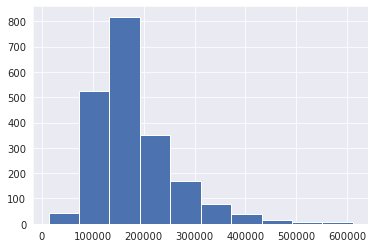

In [10]:
df_no_nulls['SalePrice'].hist()

### Selecting features for a first model

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'PID'}>,
        <AxesSubplot:title={'center':'MS SubClass'}>,
        <AxesSubplot:title={'center':'Lot Frontage'}>,
        <AxesSubplot:title={'center':'Lot Area'}>,
        <AxesSubplot:title={'center':'Overall Qual'}>],
       [<AxesSubplot:title={'center':'Overall Cond'}>,
        <AxesSubplot:title={'center':'Year Built'}>,
        <AxesSubplot:title={'center':'Year Remod/Add'}>,
        <AxesSubplot:title={'center':'Mas Vnr Area'}>,
        <AxesSubplot:title={'center':'BsmtFin SF 1'}>,
        <AxesSubplot:title={'center':'BsmtFin SF 2'}>],
       [<AxesSubplot:title={'center':'Bsmt Unf SF'}>,
        <AxesSubplot:title={'center':'Total Bsmt SF'}>,
        <AxesSubplot:title={'center':'1st Flr SF'}>,
        <AxesSubplot:title={'center':'2nd Flr SF'}>,
        <AxesSubplot:title={'center':'Low Qual Fin SF'}>,
        <AxesSubplot:title={'center':'Gr Liv Area'}>],
       [<AxesSubplot:title={'cent

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

       BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF   1st Flr SF  \
count   2050.000000   2050.000000  2050.000000    2050.000000  2051.000000   
mean     442.300488     47.959024   567.728293    1057.987805  1164.488055   
std      461.204124    165.000901   444.954786     449.410704   396.446923   
min        0.000000      0.000000     0.000000       0.000000   334.000000   
25%        0.000000      0.000000   220.000000     793.000000   879.500000   
50%      368.000000      0.000000   474.500000     994.500000  1093.000000   
75%      733.750000      0.000000   811.000000    1318.750000  1405.000000   
max     5644.000000   1474.000000  2336.000000    6110.000000  5095.000000   

        2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
count  2051.000000      2051.000000  2051.000000     2049.000000   
mean    329.329108         5.512921  1499.330083        0.427526   
std     425.671046        51.068870   500.447829        0.522673   
min       0.000000         0.000000   334.000000        0.000000   
25%       0.000000         0.000000  1129.000000        0.000000   
50%       0.000000         0.000000  1444.000000        0.000000   
75%     692.500000         0.000000  1728.500000        1.000000   
max    1862.000000      1064.000000  5642.000000        3.000000   

       Bsmt Half Bath    Full Bath    Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
count     2049.000000  2051.000000  2051.000000    2051.000000    2051.000000   
mean         0.063446     1.577279     0.371039       2.843491       1.042906   
std          0.251705     0.549279     0.501043       0.826618       0.209790   
min          0.000000     0.000000     0.000000       0.000000       0.000000   
25%          0.000000     1.000000     0.000000       2.000000       1.000000   
50%          0.000000     2.000000     0.000000       3.000000       1.000000   
75%          0.000000     2.000000     1.000000       3.000000       1.000000   
max          2.000000     4.000000     2.000000       8.000000       3.000000   

       TotRms AbvGrd   Fireplaces  Garage Yr Blt  Garage Cars  Garage Area  \
count    2051.000000  2051.000000    1937.000000  2050.000000  2050.000000   
mean        6.435885     0.590931    1978.707796     1.776585   473.671707   
std         1.560225     0.638516      25.441094     0.764537   215.934561   
min         2.000000     0.000000    1895.000000     0.000000     0.000000   
25%         5.000000     0.000000    1961.000000     1.000000   319.000000   
50%         6.000000     1.000000    1980.000000     2.000000   480.000000   


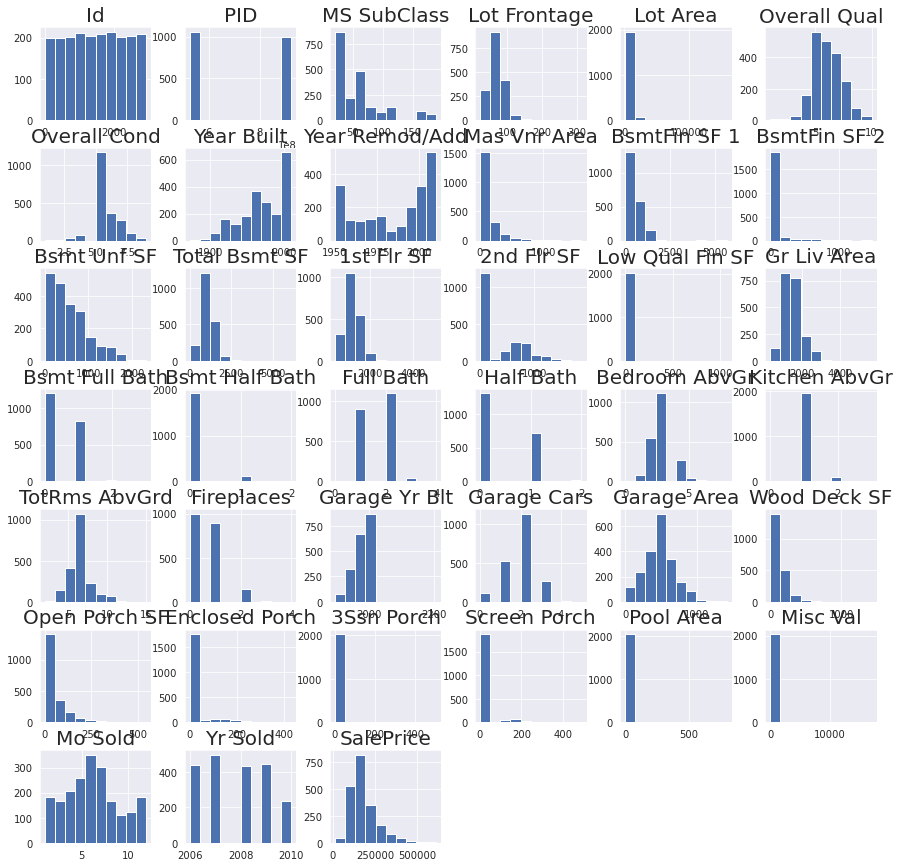

In [64]:
ames_df.hist(figsize = (15, 15));
ames_df.describe()

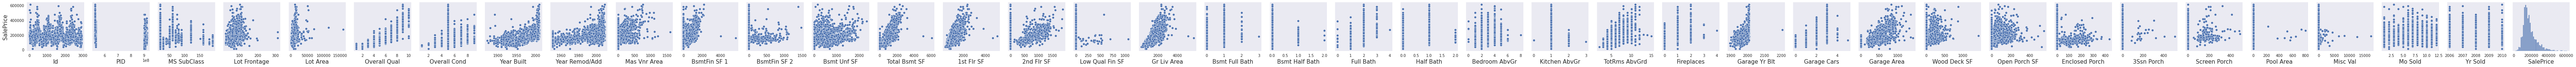

In [65]:

sns.pairplot(
    data = ames_df, x_vars = [col for col in ames_df.select_dtypes(np.number).columns], y_vars = ['SalePrice']
    
)

In [66]:
corrs = ames_df.corr()[['SalePrice']]
corrs.sort_values(by = 'SalePrice', ascending = False)

SalePrice
SalePrice         1.000000
Overall Qual      0.800207
Gr Liv Area       0.697038
Garage Area       0.650270
Garage Cars       0.648220
Total Bsmt SF     0.628925
1st Flr SF        0.618486
Year Built        0.571849
Year Remod/Add    0.550370
Full Bath         0.537969
Garage Yr Blt     0.533922
Mas Vnr Area      0.512230
TotRms AbvGrd     0.504014
Fireplaces        0.471093
BsmtFin SF 1      0.423519
Lot Frontage      0.341842
Open Porch SF     0.333476
Wood Deck SF      0.326490
Lot Area          0.296566
Bsmt Full Bath    0.283662
Half Bath         0.283001
2nd Flr SF        0.248452
Bsmt Unf SF       0.190210
Bedroom AbvGr     0.137067
Screen Porch      0.134581
3Ssn Porch        0.048732
Mo Sold           0.032735
Pool Area         0.023106
BsmtFin SF 2      0.016255
Misc Val         -0.007375
Yr Sold          -0.015203
Low Qual Fin SF  -0.041594
Bsmt Half Bath   -0.045328
Id               -0.051398
MS SubClass      -0.087335
Overall Cond     -0.097019
Kitchen AbvGr    -0.125444
Enclosed Porch   -0.135656
PID              -0.255052

In [70]:

null_counts = ames_df.isnull().sum()
columns_with_nulls = null_counts[null_counts>0].index 

#'Garage Area' and 'Garage Cars' have high correlation (>0.6) with 'SalePrice' and have only one missing value. 
#Replacing the missing value in 'Garage Area' and 'Garage Cars' with the corresponding value with closest mean price
for col in ['Garage Area', 'Garage Cars']:
    ames_df = replace_nulls_closest_mean_category(ames_df, col,'SalePrice')
    
null_counts = ames_df.isnull().sum()
columns_with_nulls = null_counts[null_counts>0].index 

#dropping the rest of the columns with null values for now
df = ames_df.drop(columns = columns_with_nulls)
df
assert(df.shape[1] + columns_with_nulls.shape[0]   == ames_df.shape[1])
df.shape

Id        PID  MS SubClass MS Zoning  Lot Area Street Lot Shape  \
0      109  533352170           60        RL     13517   Pave       IR1   
1      544  531379050           60        RL     11492   Pave       IR1   
2      153  535304180           20        RL      7922   Pave       Reg   
3      318  916386060           60        RL      9802   Pave       Reg   
4      255  906425045           50        RL     14235   Pave       IR1   
5      138  535126040           20        RL     16492   Pave       IR1   
6     2827  908186070          180        RM      3675   Pave       Reg   
7      145  535154050           20        RL     12160   Pave       IR1   
8     1942  535353130           20        RL     15783   Pave       Reg   
9     1956  535426130           60        RL     11606   Pave       IR1   
10    1044  527451290          160        RM      1680   Pave       Reg   
11    2752  906380150           20        RL      7488   Pave       IR1   
12     807  906226060           70        RL     26400   Pave       Reg   
13    1177  533236070          160        FV      2645   Pave       Reg   
14    1480  907418040           20        RL      9627   Pave       Reg   
15     324  923202105           20        RL     10114   Pave       Reg   
16    1311  902301140           70        RM      4571   Pave       Reg   
17     770  905101490           20        RL      8816   Pave       Reg   
18    2063  905107140           20        RL      8197   Pave       Reg   
19      69  528458070           60        FV      8640   Pave       Reg   
20    2062  905106150           20        RL      8724   Pave       Reg   
21     351  527131030          120        RL      5664   Pave       IR1   
22    2393  528142010           60        RL     12867   Pave       IR1   
23      12  527165230           20        RL      7980   Pave       IR1   
24    2339  527250040          190        RL     34650   Pave       Reg   
25     624  535104120           20        RL     10573   Pave       IR1   
26      86  532376160           20        RL      8450   Pave       Reg   
27    1534  909277040           50        RL     11700   Pave       IR1   
28    2243  911103060          190   C (all)      8250   Pave       Reg   
29    1957  535450190           50        RL      8064   Pave       Reg   
30     380  527355150           20        RL      9600   Pave       Reg   
31    2860  909276010           70        RL     11435   Pave       IR1   
32    2517  533250130          120        RL      9549   Pave       IR1   
33    1933  535302070           20        RL     10950   Pave       Reg   
34     820  906340110           20        RL     10637   Pave       Reg   
35     675  535426150           20        RL      9000   Pave       IR1   
36    2910  923225240          160        RM      2665   Pave       Reg   
37      21  527358140           20        RL     11751   Pave       IR1   
38    1873  534177210           20        RL      9600   Pave       Reg   
39    2125  907135050           20        RL      8428   Pave       IR2   
40    1489  908102260           20        RL      9937   Pave       Reg   
41    2383  528110050           20        RL     13891   Pave       Reg   
42     983  923275040           85        RL      9101   Pave       IR1   
43    1325  902406090           50        RM     12150   Pave       Reg   
44    1378  905102170           20        RL     11200   Pave       Reg   
45    1537  909281110           70        RL      9670   Pave       IR1   
46     905  909101140           50        RL     10998   Pave       Reg   
47    1532  909275050           70        RL      7200   Pave       Reg   
48     132  534475100           20        RL      9920   Pave       Reg   
49    1078  528188090          160        RL      2448   Pave       Reg   
50    2511  533221080          160        FV      2998   Pave       Reg   
51     912  909250220           50        RL      7804   Pave       Reg   
52    2351  527356020           6

(2051, 57)

# Numerical Columns
**Investigating 'Overall Cond' and 'Overall Qual'**

- Prices increase with 'Overall Qual' as expected
- There is negative correlation with 'Overall Cond' which is counterintuitive
- Not including 'Overall Cond' in the model
- 'Overall Qual' is featurized by mean encoding for every quality level

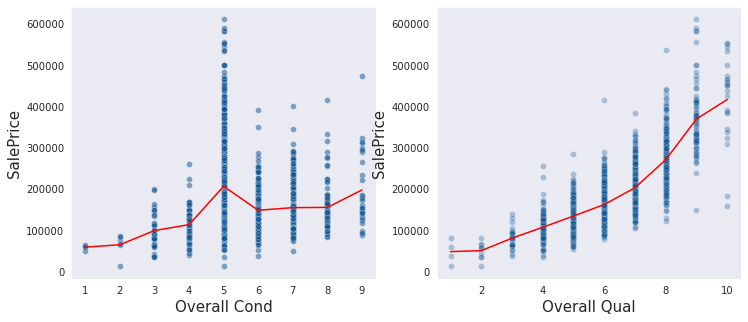

In [71]:
fig, ax = plt.subplots(1,2, figsize = (12,5));
sns.scatterplot(x = 'Overall Cond', y = 'SalePrice', data = df, ax = ax[0], color = myblue, alpha = 0.5);
sns.scatterplot(x = 'Overall Qual', y = 'SalePrice', data = df, ax = ax[1], color = myblue, alpha = 0.3);
sns.lineplot(x = 'Overall Qual', y = 'SalePrice', data = df.groupby('Overall Qual').mean(), 
             ax = ax[1], color = 'red');
sns.lineplot(x = 'Overall Cond', y = 'SalePrice', data = df.groupby('Overall Cond').mean(), 
             ax = ax[0], color = 'red');

**Garage Area and Garage Cars**

- As they are highly correlated to each other (corr = 0.89) and to SalePrice, using
only 'Garage Area' as a feature in the model

count    2051.000000
mean      473.618235
std       215.895469
min         0.000000
25%       319.000000
50%       480.000000
75%       576.000000
max      1418.000000
Name: Garage Area, dtype: float64

count    2051.000000
mean        1.776207
std         0.764543
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Garage Cars, dtype: float64

Garage Area  Garage Cars  SalePrice
Garage Area     1.000000     0.893151   0.650301
Garage Cars     0.893151     1.000000   0.648225
SalePrice       0.650301     0.648225   1.000000

count    2051.000000
mean      473.618235
std       215.895469
min         0.000000
25%       319.000000
50%       480.000000
75%       576.000000
max      1418.000000
Name: Garage Area, dtype: float64

SalePrice      
                           mean count
Garage Area_bins                     
(-0.001, 240.0]   115762.787234   235
(240.0, 294.0]    123945.715084   179
(294.0, 384.0]    132306.126168   214
(384.0, 440.0]    164881.342742   248
(440.0, 480.0]    176207.544944   178
(480.0, 516.0]    184602.822222   180
(516.0, 564.0]    197041.094340   212
(564.0, 621.0]    191494.974490   196
(621.0, 760.0]    239993.514706   204
(760.0, 1418.0]   296301.858537   205

SalePrice_mean  SalePrice_count  Garage Area_bin_average
Garage Area_bins                                                          
(-0.001, 240.0]    115762.787234              235                      120
(240.0, 294.0]     123945.715084              179                      267
(294.0, 384.0]     132306.126168              214                      339
(384.0, 440.0]     164881.342742              248                      412
(440.0, 480.0]     176207.544944              178                      460
(480.0, 516.0]     184602.822222              180                      498
(516.0, 564.0]     197041.094340              212                      540
(564.0, 621.0]     191494.974490              196                      592
(621.0, 760.0]     239993.514706              204                      690
(760.0, 1418.0]    296301.858537              205                     1089

SalePrice      
                      mean count
Garage Cars                     
0.0          105669.150442   113
1.0          126870.466667   525
2.0          184125.956866  1136
3.0          309382.745247   263
4.0          229653.846154    13
5.0          126500.000000     1

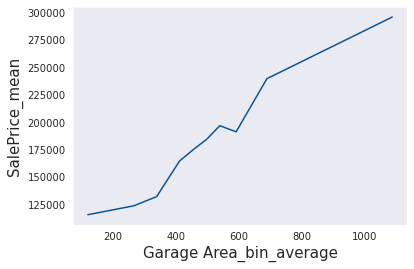

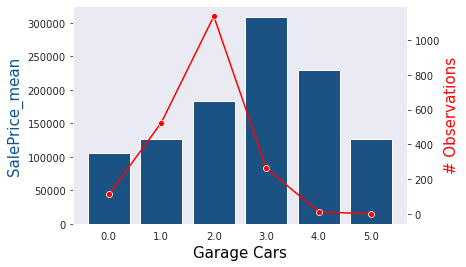

In [72]:
df['Garage Area'].describe()
df['Garage Cars'].describe()
df[['Garage Area','Garage Cars', 'SalePrice']].corr()
target = 'SalePrice'
for continuous_variable in ['Garage Area']:
    df[continuous_variable].describe()
    df_copy = df.copy()
    df_copy[f'{continuous_variable}_bins'] = pd.qcut(df_copy[continuous_variable],10, duplicates = 'drop')
    df_copy.groupby(f'{continuous_variable}_bins').agg({target:['mean', 'count']})   
    numerical_to_categorical_and_plot(continuous_variable, target, df_copy)
    
plot_bar_line('Garage Cars', 'SalePrice', df_copy)
df.groupby(['Garage Cars'])[['SalePrice']].agg(['mean','count'])


**Investigating Gr Liv Area, 1st Flr SF and 2nd Flr SF**

- They are highly correlated to each other (corr = 0.56). 
- Using only GR Liv Area as-is in the model which has a slightly higher correaltion (0.70 vs 0.62) with SalePrice



Gr Liv Area  1st Flr SF  2nd Flr SF  SalePrice
Gr Liv Area     1.000000    0.562441    0.639092   0.697038
1st Flr SF      0.562441    1.000000   -0.268855   0.618486
2nd Flr SF      0.639092   -0.268855    1.000000   0.248452
SalePrice       0.697038    0.618486    0.248452   1.000000

count    2051.000000
mean     1499.330083
std       500.447829
min       334.000000
25%      1129.000000
50%      1444.000000
75%      1728.500000
max      5642.000000
Name: Gr Liv Area, dtype: float64

SalePrice      
                           mean count
Gr Liv Area_bins                     
(333.999, 935.0]  106475.285024   207
(935.0, 1073.0]   125953.180488   205
(1073.0, 1200.0]  135269.701422   211
(1200.0, 1332.0]  154001.277778   198
(1332.0, 1444.0]  164760.936585   205
(1444.0, 1560.0]  180328.559809   209
(1560.0, 1669.0]  195643.825871   201
(1669.0, 1824.0]  216104.251208   207
(1824.0, 2142.0]  236251.758621   203
(2142.0, 5642.0]  301549.536585   205

SalePrice_mean  SalePrice_count  Gr Liv Area_bin_average
Gr Liv Area_bins                                                          
(333.999, 935.0]   106475.285024              207                      634
(935.0, 1073.0]    125953.180488              205                     1004
(1073.0, 1200.0]   135269.701422              211                     1136
(1200.0, 1332.0]   154001.277778              198                     1266
(1332.0, 1444.0]   164760.936585              205                     1388
(1444.0, 1560.0]   180328.559809              209                     1502
(1560.0, 1669.0]   195643.825871              201                     1614
(1669.0, 1824.0]   216104.251208              207                     1746
(1824.0, 2142.0]   236251.758621              203                     1983
(2142.0, 5642.0]   301549.536585              205                     3892

count    2051.000000
mean     1164.488055
std       396.446923
min       334.000000
25%       879.500000
50%      1093.000000
75%      1405.000000
max      5095.000000
Name: 1st Flr SF, dtype: float64

SalePrice      
                           mean count
1st Flr SF_bins                      
(333.999, 745.0]  120059.791262   206
(745.0, 848.0]    146497.793269   208
(848.0, 916.0]    144676.392157   204
(916.0, 1005.0]   151090.161765   204
(1005.0, 1093.0]  155830.359223   206
(1093.0, 1196.0]  173312.715686   204
(1196.0, 1329.0]  185436.024390   205
(1329.0, 1489.0]  205283.024510   204
(1489.0, 1670.0]  230575.587379   206
(1670.0, 5095.0]  302973.441176   204

SalePrice_mean  SalePrice_count  1st Flr SF_bin_average
1st Flr SF_bins                                                          
(333.999, 745.0]   120059.791262              206                     539
(745.0, 848.0]     146497.793269              208                     796
(848.0, 916.0]     144676.392157              204                     882
(916.0, 1005.0]    151090.161765              204                     960
(1005.0, 1093.0]   155830.359223              206                    1049
(1093.0, 1196.0]   173312.715686              204                    1144
(1196.0, 1329.0]   185436.024390              205                    1262
(1329.0, 1489.0]   205283.024510              204                    1409
(1489.0, 1670.0]   230575.587379              206                    1580
(1670.0, 5095.0]   302973.441176              204                    3382

count    2051.000000
mean      329.329108
std       425.671046
min         0.000000
25%         0.000000
50%         0.000000
75%       692.500000
max      1862.000000
Name: 2nd Flr SF, dtype: float64

SalePrice      
                          mean count
2nd Flr SF_bins                     
(-0.001, 396.0]  174095.786353  1231
(396.0, 623.0]   139833.682927   205
(623.0, 756.0]   165008.650718   209
(756.0, 916.0]   203370.129353   201
(916.0, 1862.0]  262694.321951   205

SalePrice_mean  SalePrice_count  2nd Flr SF_bin_average
2nd Flr SF_bins                                                         
(-0.001, 396.0]   174095.786353             1231                     198
(396.0, 623.0]    139833.682927              205                     510
(623.0, 756.0]    165008.650718              209                     690
(756.0, 916.0]    203370.129353              201                     836
(916.0, 1862.0]   262694.321951              205                    1389

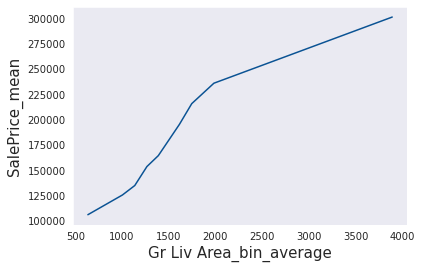

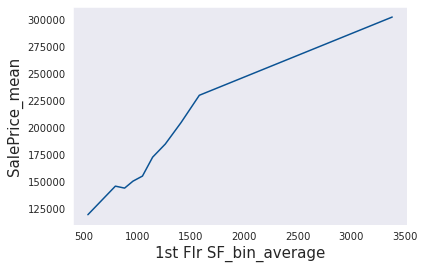

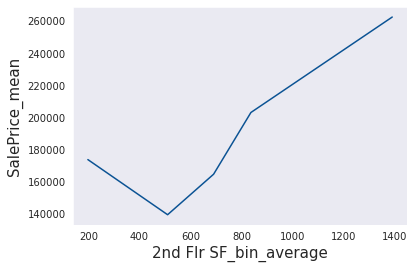

In [73]:
df[['Gr Liv Area', '1st Flr SF', '2nd Flr SF', 'SalePrice']].corr()

target = 'SalePrice'

for continuous_variable in ['Gr Liv Area', '1st Flr SF', '2nd Flr SF']:
    df[continuous_variable].describe()
    df_copy = df.copy()
    df_copy[f'{continuous_variable}_bins'] = pd.qcut(df_copy[continuous_variable],10, duplicates = 'drop')
    df_copy.groupby(f'{continuous_variable}_bins').agg({target:['mean', 'count']})   
    numerical_to_categorical_and_plot(continuous_variable, target, df_copy)

**Investigating 'Year Built' and  'Year Remod/Add'**

- 'Year Built' and  'Year Remod/Add' are both highly correlated to 'Sale Price'
-  Not a very linear relationship
-  A higher order term may be helpful


Year Built  Year Remod/Add  SalePrice
Year Built        1.000000        0.629116   0.571849
Year Remod/Add    0.629116        1.000000   0.550370
SalePrice         0.571849        0.550370   1.000000

Year Built  Year Remod/Add      SalePrice
count  2051.000000     2051.000000    2051.000000
mean   1971.708922     1984.190151  181469.701609
std      30.177889       21.036250   79258.659352
min    1872.000000     1950.000000   12789.000000
25%    1953.500000     1964.500000  129825.000000
50%    1974.000000     1993.000000  162500.000000
75%    2001.000000     2004.000000  214000.000000
max    2010.000000     2010.000000  611657.000000

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation', 'Heating',
       'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Functional', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold',
       'Sale Type', 'SalePrice', 'Year Built_bins', 'Year Remod/Add_bins'],
      dtype='object')

SalePrice
Year Built_bins                  
(1871.999, 1925.0]  123630.451613
(1925.0, 1948.0]    132371.206573
(1948.0, 1957.0]    133220.037634
(1957.0, 1965.0]    149693.585714
(1965.0, 1974.0]    146716.152709
(1974.0, 1987.0]    172621.550725
(1987.0, 1998.0]    221554.699074
(1998.0, 2003.0]    228665.065990
(2003.0, 2006.0]    242764.490842
(2006.0, 2010.0]    281111.038760

SalePrice
Year Remod/Add_bins               
(1949.999, 1959.0]   120795.997619
(1959.0, 1969.0]     144697.785714
(1969.0, 1978.0]     146530.957547
(1978.0, 1993.0]     184350.275701
(1993.0, 1998.0]     201327.363184
(1998.0, 2002.0]     205984.454545
(2002.0, 2005.0]     207636.653386
(2005.0, 2007.0]     239454.011450
(2007.0, 2010.0]     281540.104651

SalePrice_mean  SalePrice_count  Year Built_bin_average
Year Built_bins                                                            
(1871.999, 1925.0]   123630.451613              217                    1898
(1925.0, 1948.0]     132371.206573              213                    1936
(1948.0, 1957.0]     133220.037634              186                    1952
(1957.0, 1965.0]     149693.585714              210                    1961
(1965.0, 1974.0]     146716.152709              203                    1970
(1974.0, 1987.0]     172621.550725              207                    1980
(1987.0, 1998.0]     221554.699074              216                    1992
(1998.0, 2003.0]     228665.065990              197                    2000
(2003.0, 2006.0]     242764.490842              273                    2004
(2006.0, 2010.0]     281111.038760              129                    2008

SalePrice_mean  SalePrice_count  \
Year Remod/Add_bins                                    
(1949.999, 1959.0]    120795.997619              420   
(1959.0, 1969.0]      144697.785714              196   
(1969.0, 1978.0]      146530.957547              212   
(1978.0, 1993.0]      184350.275701              214   
(1993.0, 1998.0]      201327.363184              201   
(1998.0, 2002.0]      205984.454545              209   
(2002.0, 2005.0]      207636.653386              251   
(2005.0, 2007.0]      239454.011450              262   
(2007.0, 2010.0]      281540.104651               86   

                     Year Remod/Add_bin_average  
Year Remod/Add_bins                              
(1949.999, 1959.0]                         1954  
(1959.0, 1969.0]                           1964  
(1969.0, 1978.0]                           1974  
(1978.0, 1993.0]                           1986  
(1993.0, 1998.0]                           1996  
(1998.0, 2002.0]                           2000  
(2002.0, 2005.0]                           2004  
(2005.0, 2007.0]                           2006  
(2007.0, 2010.0]                           2008

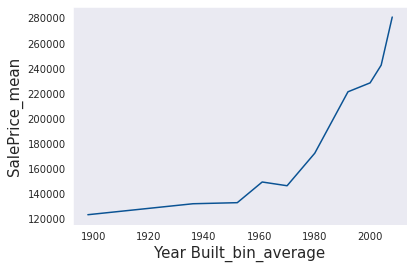

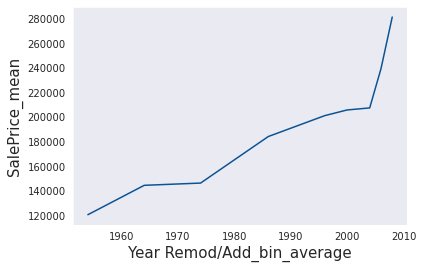

In [74]:

df[['Year Built', 'Year Remod/Add', 'SalePrice']].corr()
df[['Year Built', 'Year Remod/Add', 'SalePrice']].describe()

df_copy = df.copy()
df_copy = create_bins_cts_variable('Year Built', df_copy)
df_copy = create_bins_cts_variable('Year Remod/Add', df_copy)
df_copy.columns
df_copy.groupby(['Year Built_bins'])[['SalePrice']].agg('mean','count') 
df_copy.groupby(['Year Remod/Add_bins'])[['SalePrice']].agg('mean','count') 

numerical_to_categorical_and_plot('Year Built', 'SalePrice', df_copy)
numerical_to_categorical_and_plot('Year Remod/Add', 'SalePrice', df_copy)

**Investigating 'Yr Sold' and  'Mo Sold'**

- Mean prices have remained fairly constant by year and by month between 2006-2010
- Number of sales peaked in 2007 and have been goign down since
- Number of sales highest in summer
- not using these columns in the model for now

Yr Sold   Mo Sold  SalePrice
Yr Sold    1.000000 -0.147494  -0.015203
Mo Sold   -0.147494  1.000000   0.032735
SalePrice -0.015203  0.032735   1.000000

Yr Sold      Mo Sold      SalePrice
count  2051.000000  2051.000000    2051.000000
mean   2007.775719     6.219893  181469.701609
std       1.312014     2.744736   79258.659352
min    2006.000000     1.000000   12789.000000
25%    2007.000000     4.000000  129825.000000
50%    2008.000000     6.000000  162500.000000
75%    2009.000000     8.000000  214000.000000
max    2010.000000    12.000000  611657.000000

SalePrice
Yr Sold               
2006     179471.609589
2007     185524.514056
2008     181750.372414
2009     182455.244395
2010     174180.059829

SalePrice
Mo Sold               
1        195126.303797
2        177626.519231
3        174625.779762
4        163901.269231
5        180332.369650
6        182662.798295
7        188571.514851
8        186927.359281
9        188990.761468
10       179334.471545
11       184377.495146
12       182459.615385

SalePrice      
                          mean count
Yr Sold Mo Sold                     
2006    1        176741.666667    12
        2        182592.894737    19
        3        176811.371429    35
        4        144838.666667    36
        5        169035.096154    52
        6        176706.000000    65
        7        178504.975309    81
        8        201515.400000    30
        9        223841.032258    31
        10       165510.324324    37
        11       194654.571429    21
        12       193948.947368    19
2007    1        192601.173913    23
        2        170664.000000    26
        3        180383.658537    41
        4        162476.194444    36
        5        186866.796296    54
        6        188134.759036    83
        7        183400.944444    72
        8        196047.517857    56
        9        184522.153846    26
        10       191007.375000    32
        11       196677.354839    31
        12       187939.611111    18
2008    1        193462.666667    18
        2        155126.800000    20
        3        168420.038462    26
        4        163844.148936    47
        5        173439.425926    54
        6        194507.961538    78
        7        188316.056338    71
        8        199047.028571    35
        9        165427.045455    22
        10       170871.000000    14
        11       197643.769231    26
        12       181341.208333    24
2009    1        236103.300000    10
        2        208680.166667    18
        3        160687.903226    31
        4        187237.837838    37
        5        185570.227273    44
        6        179809.506849    73
        7        209312.773333    75
        8        157089.130435    46
        9        174131.666667    30
        10       185745.700000    40
        11       146696.000000    25
        12       165395.176471    17
2010    1        188805.625000    16
        2        176564.285714    21
        3        182650.200000    35
        4        161531.807692    52
        5        187433.358491    53
        6        167896.509434    53
        7        101125.000000     4

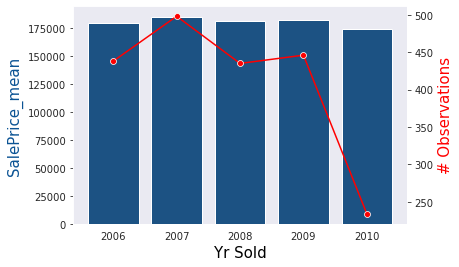

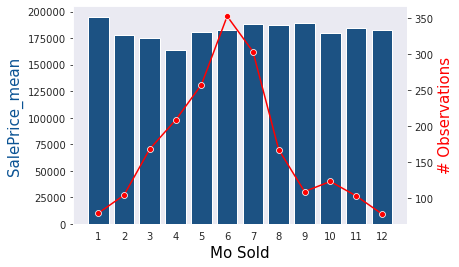

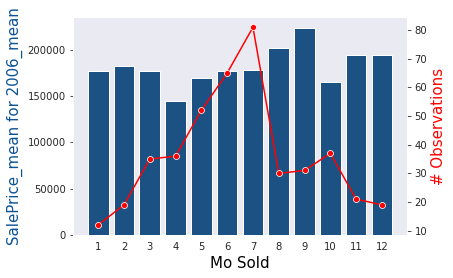

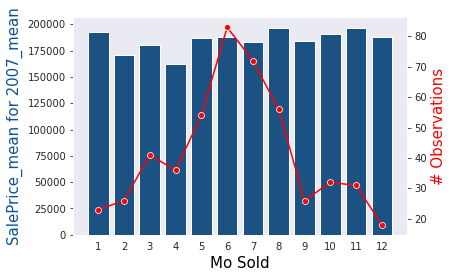

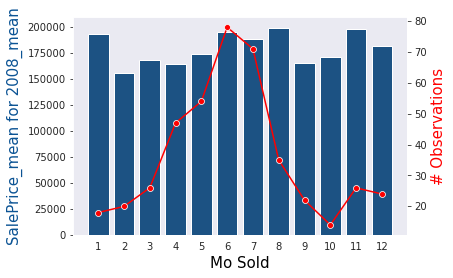

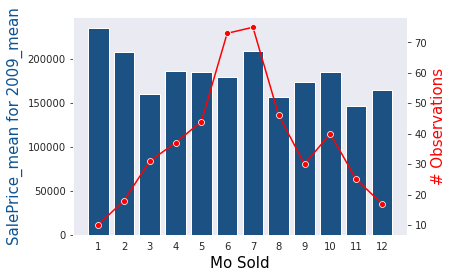

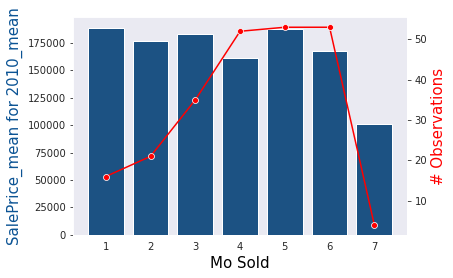

In [75]:
df[['Yr Sold', 'Mo Sold', 'SalePrice']].corr()
df[['Yr Sold', 'Mo Sold', 'SalePrice']].describe()

for col in ['Yr Sold', 'Mo Sold']:
    df_copy = df.copy()
    df_copy.groupby([col])[['SalePrice']].agg('mean','count') 
    plot_bar_line(col, 'SalePrice', df)

df_copy.groupby(['Yr Sold', 'Mo Sold'])[['SalePrice']].agg(['mean','count'])

for year in np.linspace(2006,2010,5):
    year = round(year)
    df_copy = df.copy()
    year_df = df_copy[df_copy['Yr Sold'] == year]
    year_df = year_df.rename(columns = {'SalePrice':f'SalePrice_mean for {year}'})
    plot_bar_line('Mo Sold', f'SalePrice_mean for {year}', year_df)



**Rest of the numerical columns**

- Create corresponding binary columns for 'Full Bath', 'Half Bath', 'Fireplaces'
    - Atleast_two_Full_bath (1 if Full Bath >= 2 else 0)
    - Atleast_one_Half_bath (1 if Half Bath >= 1 else 0)
    - Has_fireplace (1 if Fireplaces >=1 else 0) 
- Use 'TotRms AbvGrd' as-is even though it is non monotonic after 11, because there are very few observations greater than 11

- Not using 'Bedroom AbvGr' as it is not very linear or linearizable




SalePrice      
                    mean count
Full Bath                     
0          170226.000000     8
1          134870.961111   900
2          214600.614051  1096
3          304609.155556    45
4          269500.000000     2

SalePrice      
                    mean count
Half Bath                     
0          163751.821101  1308
1          213622.831724   725
2          173912.388889    18

SalePrice      
                        mean count
TotRms AbvGrd                     
2               39300.000000     1
3               97275.000000    12
4              127488.753425   146
5              143577.611794   407
6              164301.169179   597
7              200752.334737   475
8              216750.539474   228
9              262559.214286    98
10             285100.081633    49
11             333535.863636    22
12             265129.692308    13
13             205000.000000     1
14             200000.000000     1
15             183850.000000     1

SalePrice      
                     mean count
Fireplaces                     
0           142001.103000  1000
1           215478.776169   898
2           239893.589041   146
3           234808.333333     6
4           260000.000000     1

SalePrice      
                        mean count
Bedroom AbvGr                     
0              240791.800000     5
1              182388.920000    75
2              164656.601103   544
3              180627.309567  1108
4              215374.792453   265
5              203885.951220    41
6              164111.333333    12
8              200000.000000     1

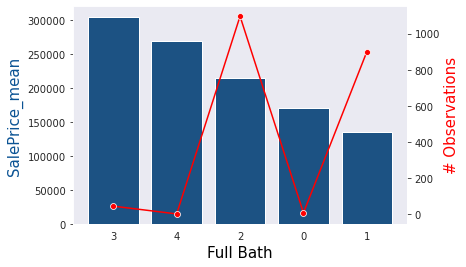

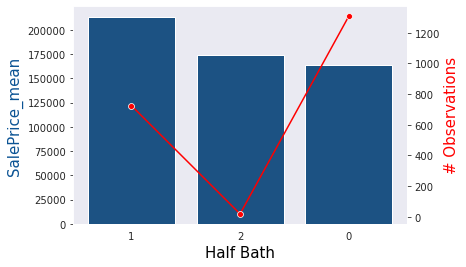

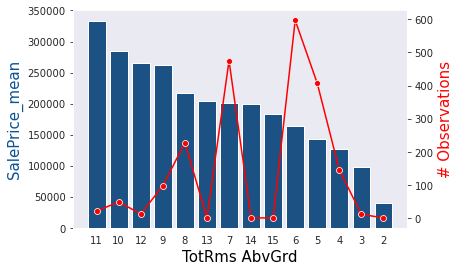

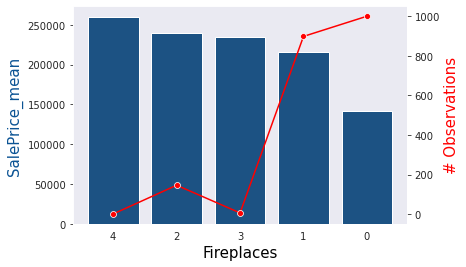

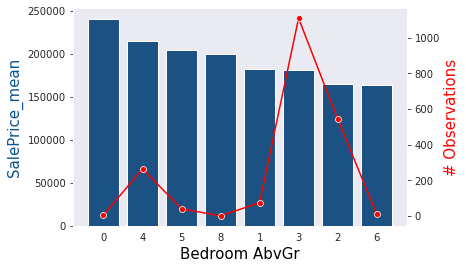

In [76]:
df.groupby(['Full Bath'])[['SalePrice']].agg({'mean','count'})
plot_bar_line('Full Bath', 'SalePrice', df, sort = True)
df.groupby(['Half Bath'])[['SalePrice']].agg({'mean','count'})
plot_bar_line('Half Bath', 'SalePrice', df, sort = True)

for col in ['TotRms AbvGrd','Fireplaces','Bedroom AbvGr']:
    df.groupby(col)[['SalePrice']].agg({'mean','count'})
    plot_bar_line(col, 'SalePrice', df , sort = True)



**MS SubClass**

- A nominal column
- mean encoding the feature

In [ ]:
MS_Subclass_df = df.groupby('MS SubClass')[['SalePrice']].agg({'mean','count'})
MS_Subclass_df.sort_values(by = ('SalePrice',  'mean'), ascending = False)
plot_bar_line('MS SubClass', 'SalePrice', df)


**Outdoor features of the house**

- 'Open Porch SF','Wood Deck SF','Lot Area' can be usedafter capping at the 90% (133, 259, 14277) respectively but using them as-is for now 

- Not using 'Screen Porch','3Ssn Porch', 'Pool Area','Enclosed Porch' as these values are non zero for less than 10% of the homes


In [ ]:
df[['Open Porch SF','Wood Deck SF','Lot Area', 'Screen Porch','3Ssn Porch', 'Pool Area','Enclosed Porch', 'SalePrice']].corr()

for continuous_variable in ['Open Porch SF','Wood Deck SF','Lot Area', 'Screen Porch','3Ssn Porch', 'Pool Area','Enclosed Porch']:
    df[continuous_variable].describe(np.append(np.linspace(0.0,1.0,11), [0.01,0.99]))
    df_copy = df.copy()
    df_copy[f'{continuous_variable}_bins'] = pd.qcut(df_copy[continuous_variable],10, duplicates = 'drop')
    df_copy.groupby(f'{continuous_variable}_bins').agg({target:['mean', 'count']})   
    
for col in ['Open Porch SF','Wood Deck SF','Lot Area']:
    df_copy = df.copy()
    numerical_to_categorical_and_plot(col, 'SalePrice', df_copy)


    


# Categorical Columns

In [77]:
ames_cat = ames_df.select_dtypes(object)
ames_cat.shape
ames_cat.columns
df_cat = df.select_dtypes(object)
df_cat.shape
df_cat.columns


(2051, 42)

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type'],
      dtype='object')

(2051, 27)

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Electrical',
       'Kitchen Qual', 'Functional', 'Paved Drive', 'Sale Type'],
      dtype='object')

- Features to Binarize:
  - 'MS Zoning': indicator being in 'FV' or 'RL' (categories with mean SalePrice > overall mean SalePrice)
  - 'Lot Config': CulDSac indicator
  - 'Condition 1': indicator for 'Condition 1' = PosN or PosA or RRNn or Norm 
  (categories with mean price > overall mean SalePrice)
  - 'Bldg Type': Twnhse and 1Fam indicator
  - 'House Style': 2 or more stories indicator
  - 'Roof Style': Hip indicator
  - 'Exterior 1st' or 'Exterior 2nd' : indicator for mean sale price >= that for VinylSd
  - 'Exter Qual' : Ex/Gd indicator
  - 'Foundation':PConc indicator
  - 'Heating QC': Ex indicator
  - 'Sale Type': New indicator
  
- 'Kitchen Qual': Mean Encode  
  
- 'Neighborhood':
  - Mean Encode or
  - indicator for top 30% and bottom 30% neighborhoods
- 'Lot Shape' : dummify
- Not including in features: 'Street', 'Land Contour', 'Utilities','Land Slope', 'Condition 2', 'Roof Matl', 'Exter Cond', 'Heating', 'Central Air', 'Electrical', Functional', 'Paved Drive'


181469.70160897123

SalePrice      
                    mean count
MS Zoning                     
FV         218618.316832   101
RL         191235.164581  1598
RH         148859.571429    14
RM         129119.142405   316
C (all)     78010.894737    19
I (all)     57625.000000     1
A (agr)     47300.000000     2

SalePrice      
                 mean count
Street                     
Pave    181793.565558  2044
Grvl     86901.428571     7

SalePrice      
                    mean count
Lot Shape                     
IR2        233954.745455    55
IR1        211848.670520   692
IR3        193182.222222     9
Reg        162925.812355  1295

SalePrice      
                       mean count
Land Contour                     
HLS           262353.376471    85
Low           199313.116279    43
Lvl           178998.564840  1843
Bnk           142868.775000    80

SalePrice      
                    mean count
Utilities                     
AllPub     181551.602245  2049
NoSeWa     137500.000000     1
NoSewr      57625.000000     1

SalePrice      
                     mean count
Lot Config                     
CulDSac     230744.358779   131
FR3         198600.000000     9
Corner      180629.591954   348
Inside      177537.014637  1503
FR2         174703.600000    60

SalePrice      
                     mean count
Land Slope                     
Mod         204639.465909    88
Sev         194598.000000    10
Gtl         180358.476703  1953

SalePrice      
                       mean count
Neighborhood                     
StoneBr       329675.736842    38
NridgHt       322831.352459   122
NoRidge       316294.125000    48
GrnHill       280000.000000     2
Veenker       253570.588235    17
Timber        241051.354167    48
Somerst       227183.900000   130
ClearCr       217490.074074    27
Crawfor       205901.211268    71
CollgCr       202497.216667   180
Blmngtn       200417.681818    22
NWAmes        194619.022989    87
Gilbert       189228.387931   116
Greens        188666.666667     3
SawyerW       187760.160920    87
Mitchel       167656.707317    82
NAmes         145905.816129   310
Blueste       144566.666667     6
NPkVill       140476.470588    17
Sawyer        137181.909910   111
Landmrk       137000.000000     1
SWISU         134758.875000    32
Edwards       130493.468531   143
BrkSide       127022.697368    76
OldTown       125276.300613   163
BrDale        103371.052632    19
IDOTRR        101103.188406    69
MeadowV       100231.250000    24

SalePrice      
                      mean count
Condition 1                     
PosN         254794.296296    27
PosA         254733.333333    12
RRNn         198208.333333     6
Norm         185007.310130  1767
RRAn         172604.777778    36
Feedr        143223.605505   109
RRAe         139685.714286    21
RRNe         129616.666667     3
Artery       128765.000000    70

SalePrice      
                      mean count
Condition 2                     
PosN         395666.666667     3
PosA         390666.666667     3
RRAe         190000.000000     1
Norm         181382.075556  2025
RRAn         136905.000000     1
Feedr        129181.818182    11
Artery       119050.000000     5
RRNn          96750.000000     2

SalePrice      
                    mean count
Bldg Type                     
TwnhsE     198312.372671   161
1Fam       185275.685882  1700
Duplex     139296.333333    75
Twnhs      133100.000000    69
2fmCon     123179.891304    46

SalePrice      
                      mean count
House Style                     
2.5Fin       243666.666667     6
2Story       206408.963211   598
2.5Unf       191785.714286    14
1Story       179809.194523  1059
SLvl         166248.989362    94
SFoyer       149343.920000    50
1.5Fin       136480.091743   218
1.5Unf       112466.666667    12

SalePrice      
                     mean count
Roof Style                     
Hip         224366.654912   397
Shed        208666.666667     3
Flat        191613.076923    13
Gable       171264.253243  1619
Mansard     152642.857143     7
Gambrel     138208.333333    12

SalePrice      
                    mean count
Roof Matl                     
WdShngl    339400.000000     5
WdShake    264250.000000     4
Membran    241500.000000     1
Tar&Grv    187948.933333    15
CompShg    180849.197037  2025
ClyTile    160000.000000     1

SalePrice      
                       mean count
Exterior 1st                     
ImStucc       262000.000000     1
Stone         258500.000000     2
CemntBd       243429.088889    90
VinylSd       218174.082873   724
BrkFace       193055.093750    64
Plywood       170511.453947   152
HdBoard       159582.473333   300
WdShing       155616.822222    45
MetalSd       154402.048338   331
Wd Sdng       142940.887681   276
Stucco        139712.962963    27
BrkComm       131000.000000     3
AsbShng       103183.333333    33
CBlock         93250.000000     2
AsphShn        82375.000000     1

SalePrice      
                       mean count
Exterior 2nd                     
CmentBd       239540.200000    90
ImStucc       227472.727273    11
VinylSd       217798.685160   721
BrkFace       187992.647059    34
Plywood       166485.713514   185
HdBoard       160836.880000   275
MetalSd       155978.635802   324
Wd Shng       154244.444444    63
Stucco        147725.333333    30
Wd Sdng       145654.396947   262
Stone         145420.666667     6
Brk Cmn       139958.823529    17
AsphShn       132125.000000     3
AsbShng       107108.928571    28
CBlock         92000.000000     2

SalePrice      
                     mean count
Exter Qual                     
Ex          374460.308642    81
Gd          230802.484935   697
TA          143270.978348  1247
Fa           89801.192308    26

SalePrice      
                     mean count
Exter Cond                     
Ex          236263.857143     7
TA          185258.202475  1778
Gd          167623.023256   215
Fa          102507.693878    49
Po           44800.000000     2

SalePrice      
                     mean count
Foundation                     
PConc       227676.483801   926
Wood        173750.000000     2
CBlock      148415.530707   863
Stone       143235.200000     5
BrkTil      129050.190045   221
Slab        108810.676471    34

SalePrice      
                 mean count
Heating                    
GasA     182422.47671  2018
GasW     151275.00000    20
OthW     125750.00000     2
Wall      77150.00000     6
Grav      65180.00000     5

SalePrice      
                     mean count
Heating QC                     
Ex          216027.607512  1065
Gd          160174.009404   319
TA          138986.705193   597
Fa          117123.641791    67
Po           69033.333333     3

<ipython-input-62-c3e0a21c4677>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


SalePrice      
                      mean count
Central Air                     
Y            187441.503665  1910
N            100575.078014   141

SalePrice      
                     mean count
Electrical                     
SBrkr       187770.382227  1868
FuseA       122565.157143   140
FuseF       103678.914286    35
FuseP        83485.714286     7
Mix          67000.000000     1

SalePrice      
                       mean count
Kitchen Qual                     
Ex            336424.463576   151
Gd            211629.451613   806
TA            139501.607450  1047
Fa            101334.957447    47

SalePrice      
                     mean count
Functional                     
Typ         183954.749347  1915
Maj1        163106.166667    12
Min1        154429.761905    42
Min2        150424.571429    42
Mod         148108.724138    29
Sev          95750.000000     2
Maj2         87157.714286     7
Sal          31550.000000     2

SalePrice      
                      mean count
Paved Drive                     
Y            188792.163890  1861
P            129824.461538    39
N            104562.827815   151

SalePrice      
                    mean count
Sale Type                     
New        279021.056250   160
Con        241807.500000     4
ConLI      207992.857143     7
CWD        186635.000000    10
WD         174912.251544  1781
COD        133574.523810    63
ConLD      129091.352941    17
Oth        127497.750000     4
ConLw      124600.000000     5

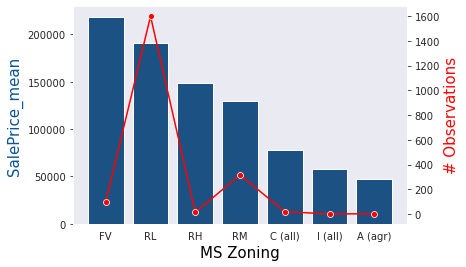

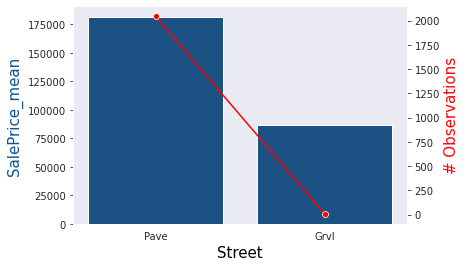

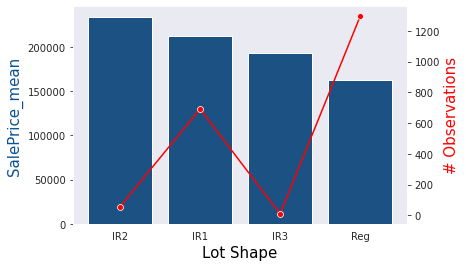

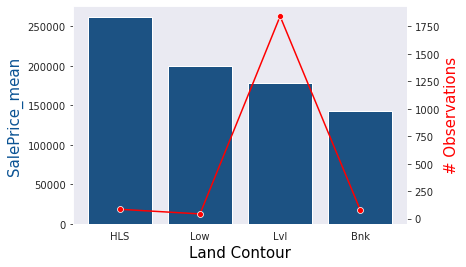

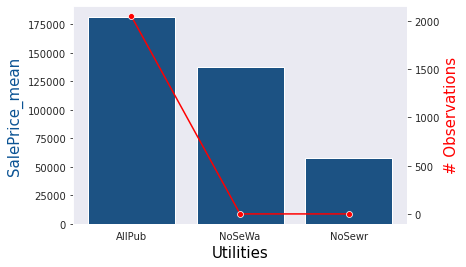

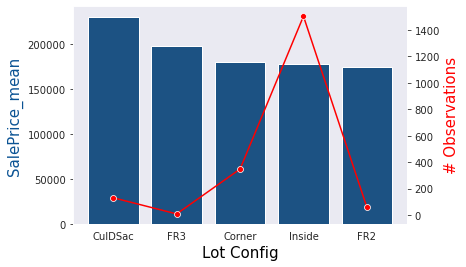

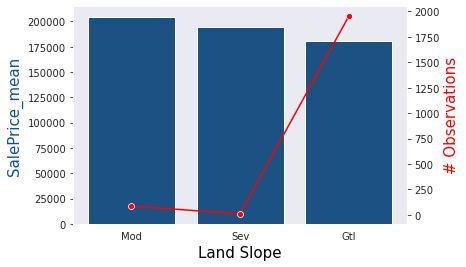

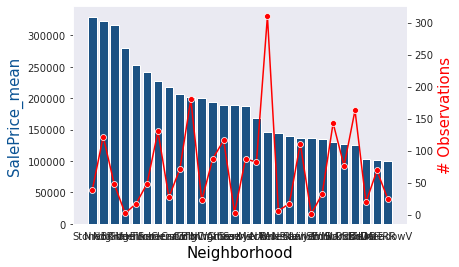

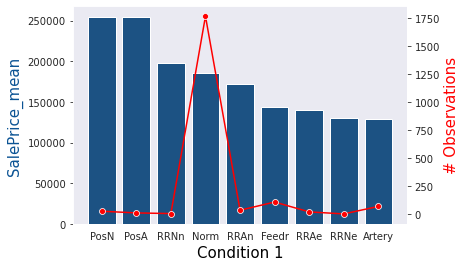

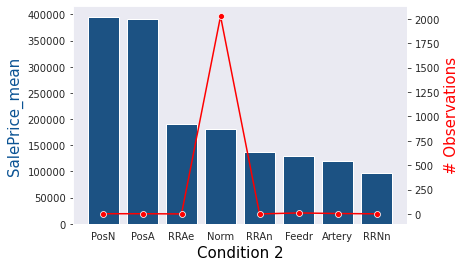

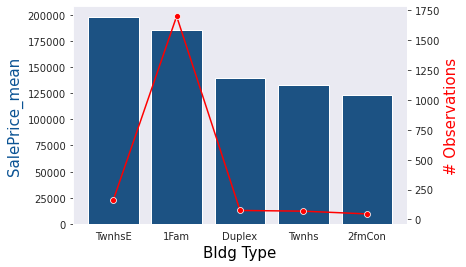

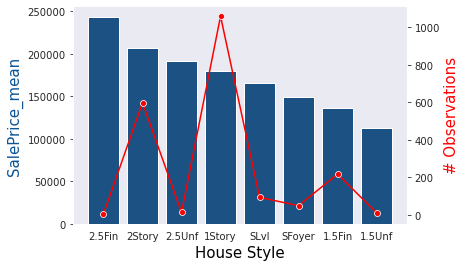

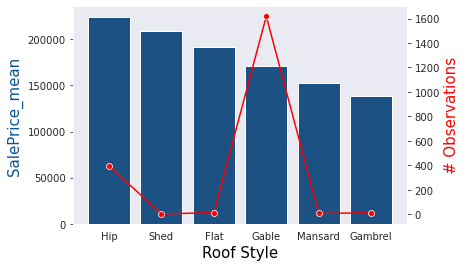

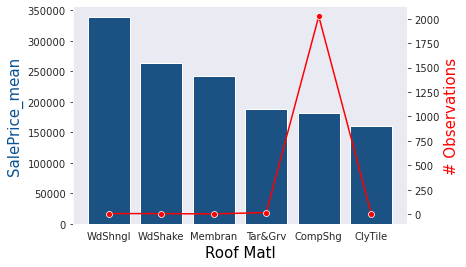

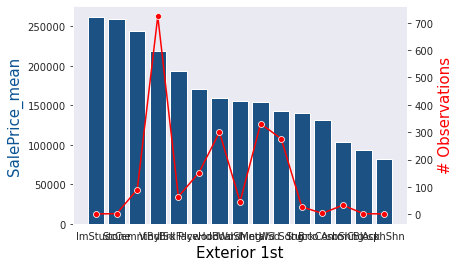

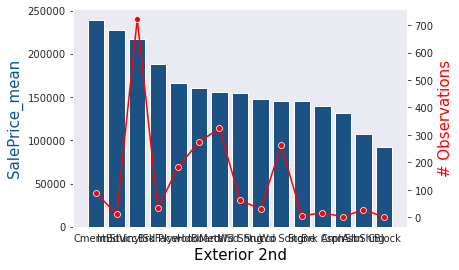

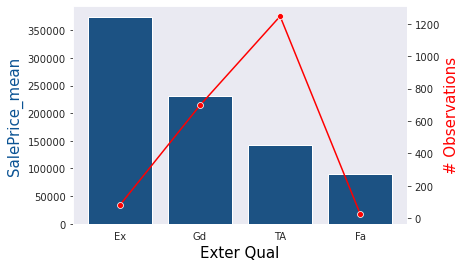

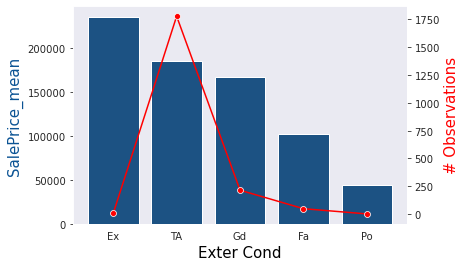

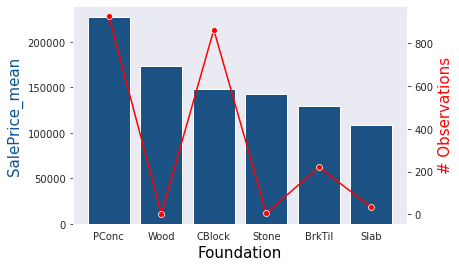

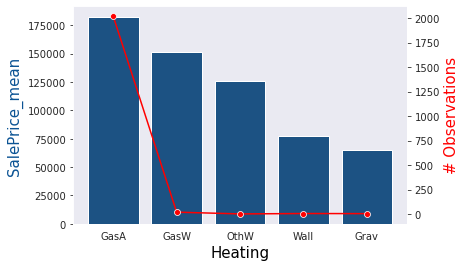

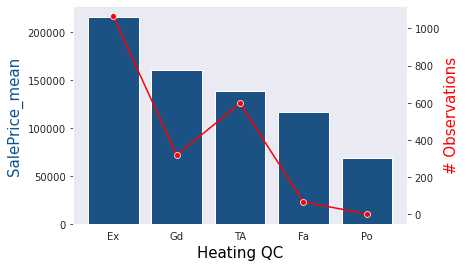

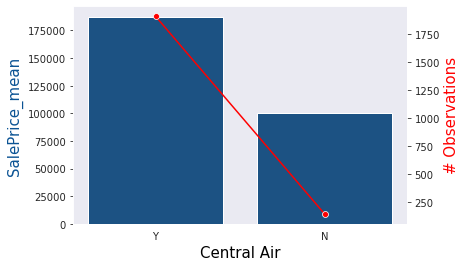

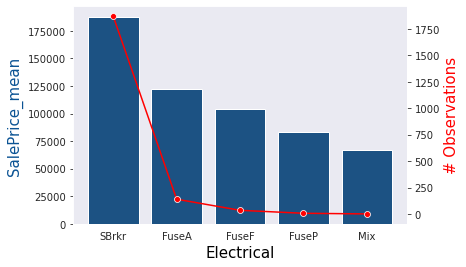

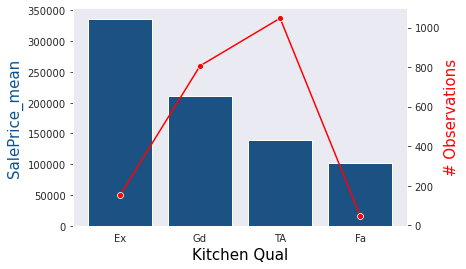

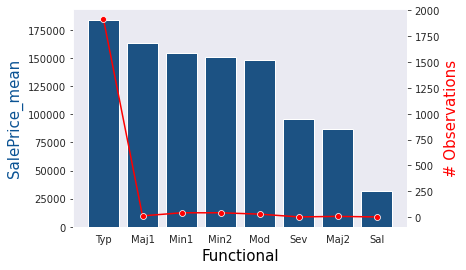

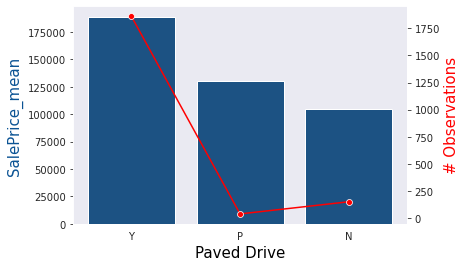

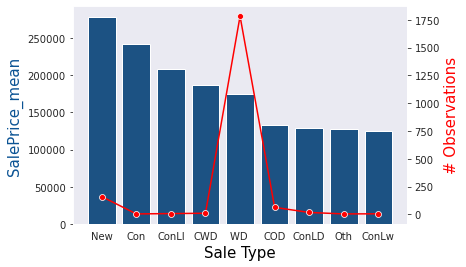

In [78]:
df['SalePrice'].mean()
for col in df_cat.columns:
    df.groupby(col)[['SalePrice']].agg({'mean','count'}).sort_values(by = ('SalePrice', 'mean'), ascending = False)
    plot_bar_line(col, 'SalePrice', df, sort = True)

In [79]:

#numerical features
#choosing 13/39(28 without any nulls) columns based on the analysis above
num_columns_to_mean_encode = ['Overall Qual' , 'MS SubClass']
num_columns_to_binarize = ['Full Bath' , 'Half Bath', 'Fireplaces']
num_continuous_variables = ['Gr Liv Area', 'Year Built','Year Remod/Add', 'Garage Area'] #to be used as-is
num_columns_that_may_be_capped = ['TotRms AbvGrd','Open Porch SF','Wood Deck SF','Lot Area'] 
# will be used as-is as only 10% are above the capping values decided earlier

#categorical features
#choosing 14/42 columns (27 with no nulls) based on analysis above
cat_cols_to_binarize = ['MS Zoning', 
       'Lot Config', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Style', 
       'Exterior 2nd', 'Exter Qual', 
       'Foundation', 'Heating QC',
       'Sale Type']
cat_columns_to_mean_encode = ['Kitchen Qual','Neighborhood']
cat_columns_to_dummify = ['Lot Shape']



In [80]:
#drop columns that are not being used

feature_columns =(
                 num_columns_to_mean_encode
                 +num_columns_to_binarize
                 +num_continuous_variables
                 +num_columns_that_may_be_capped
                 +cat_cols_to_binarize
                 +cat_columns_to_mean_encode
                 +cat_columns_to_dummify
                 
) 
columns_to_drop = [col for col in df.columns if col not in feature_columns + ['SalePrice']]
featurized_df = df[feature_columns].copy()

featurized_df.columns

columns_to_drop

Index(['Overall Qual', 'MS SubClass', 'Full Bath', 'Half Bath', 'Fireplaces',
       'Gr Liv Area', 'Year Built', 'Year Remod/Add', 'Garage Area',
       'TotRms AbvGrd', 'Open Porch SF', 'Wood Deck SF', 'Lot Area',
       'MS Zoning', 'Lot Config', 'Condition 1', 'Bldg Type', 'House Style',
       'Roof Style', 'Exterior 2nd', 'Exter Qual', 'Foundation', 'Heating QC',
       'Sale Type', 'Kitchen Qual', 'Neighborhood', 'Lot Shape'],
      dtype='object')

['Id',
 'PID',
 'Street',
 'Land Contour',
 'Utilities',
 'Land Slope',
 'Condition 2',
 'Overall Cond',
 'Roof Matl',
 'Exterior 1st',
 'Exter Cond',
 'Heating',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Functional',
 'Garage Cars',
 'Paved Drive',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold']

In [84]:
Mean_maps = {col : df.groupby([col])[['SalePrice']].mean() 
             for col in ['Overall Qual' , 'MS SubClass', 'Kitchen Qual','Neighborhood']}
Mean_maps['Kitchen Qual'].loc['Po',:] =  Mean_maps['Kitchen Qual'].loc['Fa','SalePrice']

def treat_features(X , Mean_maps):
    
    for col in num_columns_to_mean_encode + cat_columns_to_mean_encode:
        X[col]=X[col].map(lambda x : Mean_maps[col].loc[x,'SalePrice'])        
    X.loc[:,'Full Bath'] = X.loc[:,'Full Bath'].map(lambda x : 1 if x >= 2 else 0) #indicator for Full Bath >= 2
    X.loc[:,'Half Bath'] = X.loc[:,'Half Bath'].map(lambda x : 1 if x >= 1 else 0) #indicator for Half Bath >= 1
    X.loc[:,'Fireplaces'] = X.loc[:,'Fireplaces'].map(lambda x : 1 if x >= 1 else 0) #indicator for  Fireplaces >= 1
    X.loc[:,'MS Zoning'] = X.loc[:,'MS Zoning'].map(lambda x : 1 if ((x == 'FV') or (x=='RL')) else 0)
    X.loc[:,'Lot Config'] = X.loc[:,'Lot Config'].map(lambda x : 1 if x=='CulDSac' else 0)
    X.loc[:,'Condition 1'] = X.loc[:,'Condition 1'].map(lambda x : 1 if ((x=='PosN') or (x=='PosA') or 
                                                             (x=='RRNn') or (x=='Norm')) else 0)
    X.loc[:,'Bldg Type'] = X.loc[:,'Bldg Type'].map(lambda x : 1 if ((x == 'TwnhsE') or (x=='1Fam')) else 0)
    X.loc[:,'House Style'] = X.loc[:,'House Style'].map(lambda x : 1 if ((x=='2.5Fin') or (x=='2.5Unf') or 
                                                             (x=='2Story')) else 0)
    X.loc[:,'Roof Style'] = X.loc[:,'Roof Style'].map(lambda x : 1 if x=='Hip' else 0)
    X.loc[:,'Exterior 2nd'] = X.loc[:,'Exterior 2nd'].map(lambda x : 1 if x in ['CmentBd','ImStucc','VinylSd'] else 0)
    X.loc[:,'Exter Qual'] = X.loc[:,'Exter Qual'].map(lambda x : 1 if x in ['Ex','Gd'] else 0)
    X.loc[:,'Foundation'] = X.loc[:,'Foundation'].map(lambda x : 1 if x in ['PConc'] else 0)
    X.loc[:,'Heating QC'] = X.loc[:,'Heating QC'].map(lambda x : 1 if x in ['Ex'] else 0)
    X.loc[:,'Sale Type'] = X.loc[:,'Sale Type'].map(lambda x : 1 if x in ['New'] else 0)
    X = pd.get_dummies(X, columns=['Lot Shape'], drop_first=True)
    return X




In [99]:
X = df[feature_columns].copy() 
X = treat_features(X,Mean_maps)
y = df['SalePrice'].copy()


# Fitting the model and Cross Validation

In [87]:
X.head()

Overall Qual    MS SubClass  Full Bath  Half Bath  Fireplaces  \
0  162891.102767  239225.769036          1          1           0   
1  203430.285383  239225.769036          1          1           1   
2  134963.644760  189305.488312          0          0           0   
3  134963.644760  239225.769036          1          1           0   
4  162891.102767  137270.000000          1          0           0   

   Gr Liv Area  Year Built  Year Remod/Add  Garage Area  TotRms AbvGrd  \
0         1479        1976            2005        475.0              6   
1         2122        1996            1997        559.0              8   
2         1057        1953            2007        246.0              5   
3         1444        2006            2007        400.0              7   
4         1445        1900            1993        484.0              6   

   Open Porch SF  Wood Deck SF  Lot Area  MS Zoning  Lot Config  Condition 1  \
0             44             0     13517          1           1            0   
1             74             0     11492          1           1            1   
2             52             0      7922          1           0            1   
3              0           100      9802          1           0            1   
4             59             0     14235          1           0            1   

   Bldg Type  House Style  Roof Style  Exterior 2nd  Exter Qual  Foundation  \
0          1            1           0             0           1           0   
1          1            1           0             1           1           1   
2          1            0           0             1           0           0   
3          1            1           0             1           0           1   
4          1            0           0             0           0           1   

   Heating QC  Sale Type   Kitchen Qual   Neighborhood  Lot Shape_IR2  \
0           1          0  211629.451613  137181.909910              0   
1           1          0  211629.451613  187760.160920              0   
2           0          0  211629.451613  145905.816129              0   
3           0          0  139501.607450  241051.354167              0   
4           0          0  139501.607450  187760.160920              0   

   Lot Shape_IR3  Lot Shape_Reg  
0              0              0  
1              0              0  
2              0              1  
3              0              1  
4              0              0

In [90]:

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=2)
model1 = LinearRegression()


In [116]:
cross_val_score(estimator=model1, X=X_train, y=y_train, cv=7)



array([0.87603124, 0.89538745, 0.85619111, 0.84276351, 0.87191432,
       0.90525039, 0.86620966])

In [97]:
model1.fit(X_train,y_train)
model1.score(X_train,y_train)
model1.score(X_test,y_test)

pd.DataFrame(list(zip(feature_columns, model1.coef_)), 
             columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending = False)

LinearRegression()

0.8822017554942321

0.7695546773412534

Feature   Coefficient
23       Sale Type  17861.804061
18      Roof Style   8000.267203
15     Condition 1   7471.015061
4       Fireplaces   5924.238127
26       Lot Shape   4768.728128
22      Heating QC   3416.229890
16       Bldg Type   3181.824031
14      Lot Config   3056.342517
13       MS Zoning   2625.390648
21      Foundation   1069.357819
19    Exterior 2nd    789.704650
6       Year Built    248.178149
7   Year Remod/Add    155.950590
5      Gr Liv Area     67.059861
10   Open Porch SF     33.840732
11    Wood Deck SF     29.878645
8      Garage Area     24.781779
12        Lot Area      0.685669
0     Overall Qual      0.398050
24    Kitchen Qual      0.170818
25    Neighborhood      0.164771
1      MS SubClass      0.004986
9    TotRms AbvGrd  -1283.829990
3        Half Bath  -2483.232162
20      Exter Qual  -8667.992978
2        Full Bath -12989.431106
17     House Style -15569.478294

In [130]:
model_stats_1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
not_sig_coefs = [x for x in model_stats_1.pvalues.index if model_stats_1.pvalues[x] > 0.05]
not_sig_coefs
model_stats_1.summary()

/home/suma/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['MS SubClass',
 'Half Bath',
 'TotRms AbvGrd',
 'MS Zoning',
 'Lot Config',
 'Bldg Type',
 'Exterior 2nd',
 'Foundation',
 'Heating QC',
 'Lot Shape_IR2',
 'Lot Shape_IR3',
 'Lot Shape_Reg']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     362.8
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        21:26:12   Log-Likelihood:                -16714.
No. Observations:                1435   AIC:                         3.349e+04
Df Residuals:                    1405   BIC:                         3.365e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.692e+05   1.39e+05     -6.271      0.000   -1.14e+06   -5.97e+05
Overall Qual       0.3980      0.021     18.552      0.000       0.356       0.440
MS SubClass        0.0050      0.032      0.157      0.876      -0.057       0.067
Full Bath      -1.299e+04   2351.270     -5.524      0.000   -1.76e+04   -8377.053
Half Bath      -2483.2322   2226.519     -1.115      0.265   -6850.892    1884.428
Fireplaces      5924.2381   1791.613      3.307      0.001    2409.714    9438.762
Gr Liv Area       67.0599      3.663     18.307      0.000      59.874      74.246
Year Built       248.1781     54.516      4.552      0.000     141.237     355.119
Year Remod/Add   155.9506     53.813      2.898      0.004      50.389     261.512
Garage Area       24.7818      4.654      5.324      0.000      15.651      33.912
TotRms AbvGrd  -1283.8300    875.465     -1.466      0.143   -3001.189     433.529
Open Porch SF     33.8407     12.662      2.673      0.008       9.002      58.680
Wood Deck SF      29.8786      6.452      4.631      0.000      17.222      42.536
Lot Area           0.6857      0.135      5.075      0.000       0.421       0.951
MS Zoning       2625.3906   2463.424      1.066      0.287   -2206.995    7457.776
Lot Config      3056.3425   3287.961      0.930      0.353   -3393.499    9506.184
Condition 1     7471.0151   2388.900      3.127      0.002    2784.819    1.22e+04
Bldg Type       3181.8240   3176.970      1.002      0.317   -3050.291    9413.939
House Style    -1.557e+04   2574.501     -6.048      0.000   -2.06e+04   -1.05e+04
Roof Style      8000.2672   2043.888      3.914      0.000    3990.866     1.2e+04
Exterior 2nd     789.7047   2033.122      0.388      0.698   -3198.577    4777.986
Exter Qual     -8667.9930   2690.540     -3.222      0.001   -1.39e+04   -3390.085
Foundation      1069.3578   2420.819      0.442      0.659   -3679.452    5818.168
Heating QC      3416.2299   1932.089      1.768      0.077    -373.861    7206.320
Sale Type       1.786e+04   3097.189      5.767      0.000    1.18e+04    2.39e+04
Kitchen Qual       0.1708      0.021      7.947      0.000       0.129       0.213
Neighborhood       0.1648      0.022      7.486      0.000       0.122       0.208
Lot Shape_IR2   4768.7281   5135.740      0.929      0.353   -5305.816    1.48e+04
Lot Shape_IR3  -1.156e+04   1.28e+04     -0.905      0.365   -3.66e+04    1.35e+04
Lot Shape_Reg  -1683.0609   1820.251     -0.925      0.355   -5253.763    1887.642
==============================================================================
Omnibus:                      292.626   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3916.729
Skew:                           0.545   Prob(JB):                         0.00
Kurtosis:                   

In [160]:

fewer_features = [x for x in X.columns if x not in not_sig_coefs]
fewer_features.remove('House Style')
fewer_features.remove('Full Bath')
fewer_features.remove('Year Built')
fewer_features.remove('Exter Qual')
fewer_features.remove('Kitchen Qual')
fewer_features.remove('Lot Area')
fewer_features.remove('Condition 1')
fewer_features.remove('Fireplaces')


fewer_features

['Overall Qual',
 'Gr Liv Area',
 'Year Remod/Add',
 'Garage Area',
 'Open Porch SF',
 'Wood Deck SF',
 'Roof Style',
 'Sale Type',
 'Neighborhood']

In [161]:

X_fewer_features = X[fewer_features].copy()

X2_train, X2_test, y2_train, y2_test = train_test_split(X_fewer_features, y,test_size=0.3,random_state=2)

model2 = LinearRegression()
cross_val_score(X= X2_train, y = y2_train,estimator = model2,cv = 7)

model_stats_2 = sm.OLS(y_train, sm.add_constant(X2_train)).fit()
model_stats_2.summary()


array([0.83550018, 0.87322196, 0.84450672, 0.80953351, 0.85346339,
       0.88923698, 0.84306077])

/home/suma/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     920.1
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        21:50:05   Log-Likelihood:                -16872.
No. Observations:                1435   AIC:                         3.376e+04
Df Residuals:                    1425   BIC:                         3.382e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.444e+05   9.59e+04     -4.635      0.000   -6.33e+05   -2.56e+05
Overall Qual       0.4653      0.021     22.170      0.000       0.424       0.506
Gr Liv Area       49.4033      2.185     22.608      0.000      45.117      53.690
Year Remod/Add   198.9031     49.195      4.043      0.000     102.400     295.406
Garage Area       40.6564      4.924      8.257      0.000      30.997      50.316
Open Porch SF     41.9604     13.738      3.054      0.002      15.012      68.909
Wood Deck SF      43.7721      7.048      6.211      0.000      29.947      57.598
Roof Style      1.497e+04   2162.425      6.924      0.000    1.07e+04    1.92e+04
Sale Type       1.975e+04   3345.395      5.905      0.000    1.32e+04    2.63e+04
Neighborhood       0.2402      0.021     11.360      0.000       0.199       0.282
==============================================================================
Omnibus:                      280.164   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2343.553
Skew:                           0.661   Prob(JB):                         0.00
Kurtosis:                       9.119   Cond. No.                     3.15e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [164]:
X_unknown = test.copy()
model_f = LinearRegression()
model_f.fit(X_fewer_features, y)
test_X = treat_features(X_unknown[feature_columns],Mean_maps)

preds1 = model_f.predict(test_X[fewer_features])
len(preds1)
test['Id']
submission3 = pd.DataFrame({'Id':test['Id'],'SalePrice':preds1})
submission3.to_csv('../datasets/submission3.csv',index = False)

LinearRegression()

<ipython-input-84-221a7b1d9a55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col]=X[col].map(lambda x : Mean_maps[col].loc[x,'SalePrice'])
/home/suma/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


878

0      2658
1      2718
2      2414
3      1989
4       625
5       333
6      1327
7       858
8        95
9      1568
10     2482
11     1364
12     2584
13      818
14     2673
15     2089
16     1297
17      790
18     2616
19      720
20      222
21      557
22     1148
23     2766
24      534
25     1452
26      630
27     2648
28      125
29     1904
30     1670
31      756
32      717
33     1032
34      852
35     1731
36     2639
37     2071
38     1267
39     1851
40      567
41     2439
42     1898
43      647
44     2256
45      979
46     1444
47     2485
48      157
49       88
50     2003
51      186
52     1425
53     2695
54      738
55      395
56     1353
57     1878
58      390
59     1456
60     1103
61     1387
62     2070
63     1199
64     2479
65      501
66     2362
67     1718
68     2188
69     1483
70     2557
71      437
72     2224
73     1628
74      397
75      587
76      971
77     2611
78     1887
79     2399
80     2148
81      304
82     1997
83  